In [25]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import sys, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA
from prophet import Prophet as prophet_model_lib
from sklearn.metrics import f1_score, recall_score, precision_score

import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import plotly.express as px


## Functions

In [26]:
def plot_outlier(predicted_df):
    fig, ax = plt.subplots(figsize=(18,6))
    outlier_points = predicted_df.loc[predicted_df['prediction'] == 1] #anomaly
    ax.plot(predicted_df.index, predicted_df['value'], color='blue', label = 'Normal')
    ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show()
    # return ax

## Load & Preprocess Data

In [27]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df = df.head(1000)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
# df = df.asfreq(freq='T')
# df = df.interpolate()
df['label'] = df.label.astype(int)

In [28]:
df_hourly = df.resample('H').mean()

In [29]:
# Create a TimeSeries, specifying the time and value columns
# Set aside the last 20 percent of ts as a validation series

# series = TimeSeries.from_dataframe(df, value_cols='value')
# train, val = series[:-round(len(df) / 5)], series[-round(len(df) / 5):]

In [30]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df['value'].values.reshape(-1, 1))
df['scaled'] = np_scaled
data = df['scaled'].to_frame()

In [31]:
train, val = train_test_split(df, train_size=0.7, shuffle=False)

exp_model = ExponentialSmoothing(seasonal_periods=seasonality_period)
exp_model.fit(train)
exp_prediction = exp_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
exp_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

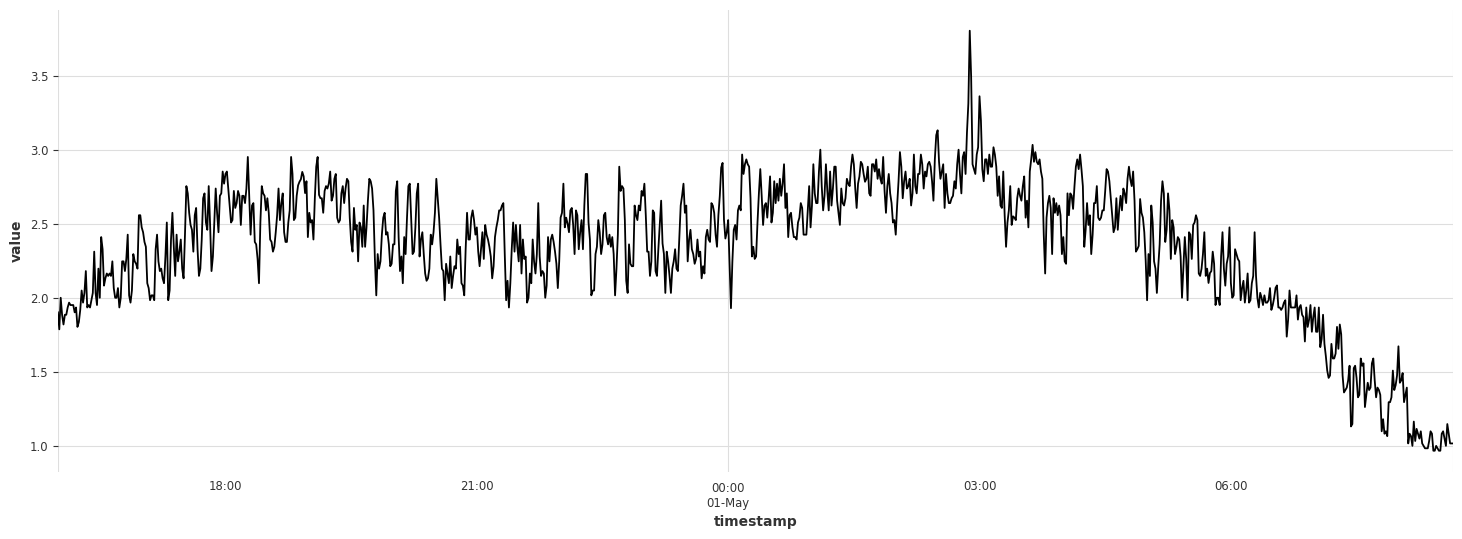

In [32]:
# Plot the time series
plt.rcParams["figure.figsize"] = (18,6)
df.value.plot()
plt.ylabel("value")
plt.show()

In [33]:
# Check occurence of seasonality and find the period of it
# is_sesonal, seasonality_period = check_seasonality(ts = series, m = None, max_lag = 100, alpha = 0.05)
# print("Seasonal:", is_sesonal, "Period:", seasonality_period)

In [34]:
# Checking being stationary or non stationary
# is_Stationary = stationarity_tests(ts = series, p_value_threshold_adfuller = 0.05, p_value_threshold_kpss = 0.05)
# if is_Stationary == False:
#     # Parameters can be changed to fit better
#     series = series.diff()
# else:
#     print("stationary already")

## Exponential Smoothing

In [35]:
# exp_model = ExponentialSmoothing(seasonal_periods=seasonality_period)
# exp_model.fit(train)
# exp_prediction = exp_model.predict(len(val), num_samples=1000)
# # Plotting the predictions
# series.plot()
# exp_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# plt.legend()

In [36]:
# arima_model = ARIMA(9, 1, 5)
# arima_model.fit(train)
# arima_prediction = arima_model.predict(len(val), num_samples=1000)
# # Plotting the predictions
# series.plot()
# arima_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# plt.legend()

In [37]:
# prophet_model = Prophet()
# prophet_model.fit(train)
# prophet_prediction = prophet_model.predict(len(val), num_samples=1000)
# # Plotting the predictions
# series.plot()
# prophet_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# plt.legend()

## Prophet

15:52:03 - cmdstanpy - INFO - Chain [1] start processing
15:52:10 - cmdstanpy - INFO - Chain [1] done processing


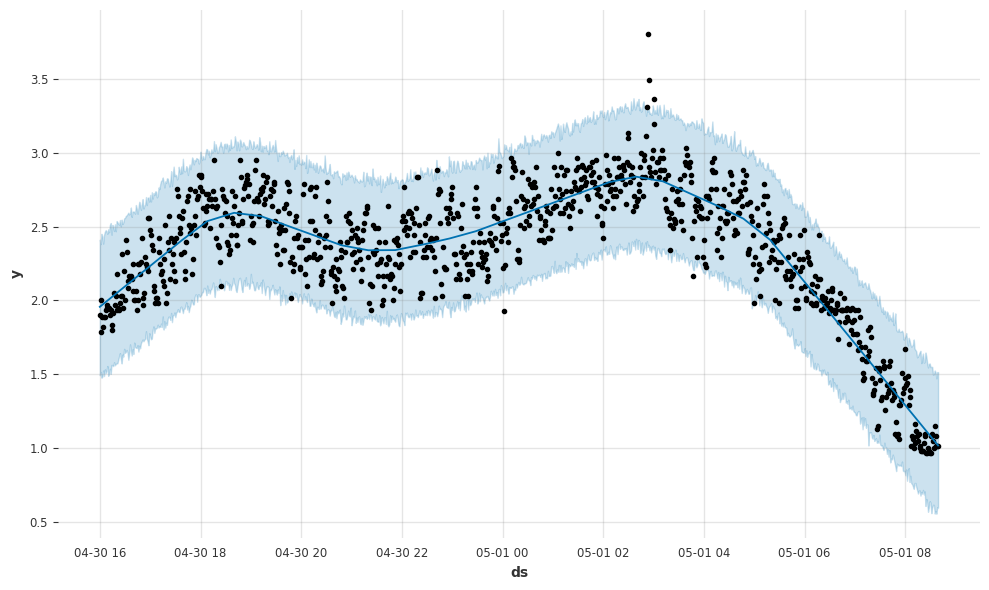

In [38]:
# train_df = TimeSeries.pd_dataframe(series).reset_index()
train_df = df['value'].reset_index()
train_df.columns = ["ds","y"]

# model preparation
prophet_model = prophet_model_lib(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
seasonality_mode = 'additive', interval_width = 0.99, changepoint_range = 0.8)
prophet_model = prophet_model.fit(train_df)

# forecast
forecast = prophet_model.predict(train_df)
prophet_model.plot(forecast)
plt.show()

In [39]:
# metrics of prediction
performance = pd.merge(train_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE {performance_MAE}')
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'MAPE {performance_MAPE}')

The MAE 0.1479063198578529
MAPE 0.06521553480610628


In [40]:
# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# anomalies dataframe
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
144,2017-04-30 18:24:00,2.098361,2.564989,2.113211,3.073402,1
228,2017-04-30 19:48:00,2.016393,2.496859,2.061308,2.984011,1
379,2017-04-30 22:19:00,2.836066,2.371412,1.887788,2.821579,1
482,2017-05-01 00:02:00,1.929825,2.539496,2.086712,3.056601,1
652,2017-05-01 02:52:00,3.311476,2.825024,2.401757,3.301461,1
653,2017-05-01 02:53:00,3.803279,2.824039,2.362851,3.277605,1
654,2017-05-01 02:54:00,3.491803,2.823053,2.377217,3.304046,1
660,2017-05-01 03:00:00,3.360656,2.817140,2.344553,3.290180,1
679,2017-05-01 03:19:00,2.344262,2.786008,2.345117,3.236174,1
707,2017-05-01 03:47:00,2.163934,2.714985,2.207997,3.200411,1


<AxesSubplot:xlabel='ds', ylabel='y'>

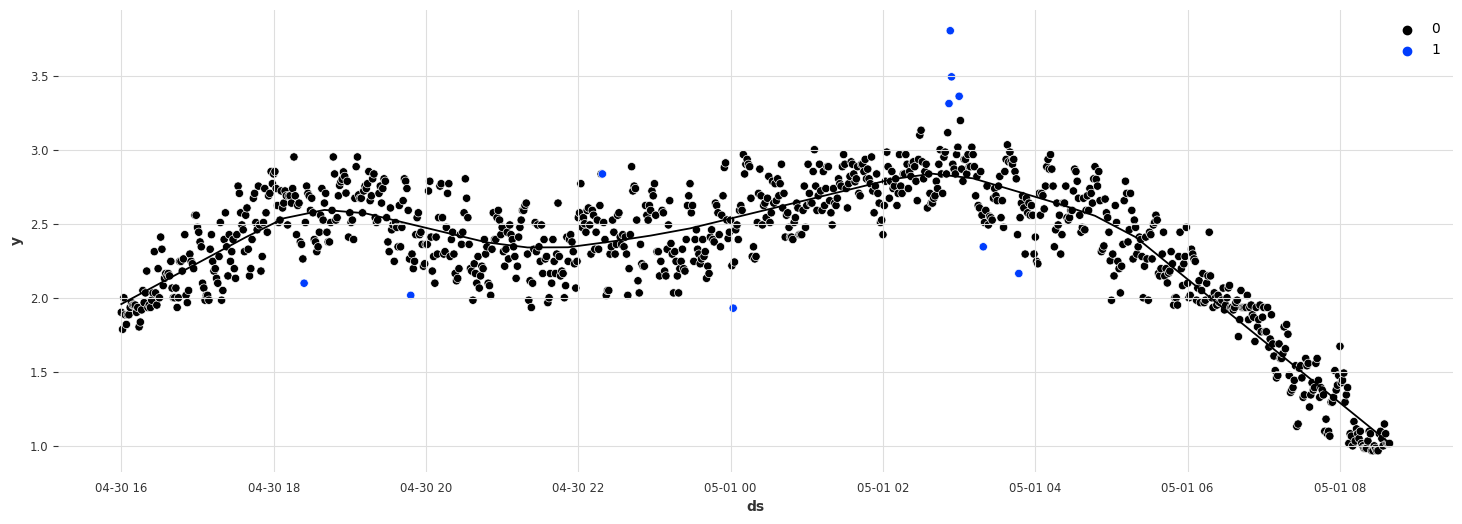

In [41]:
# Visualize the anomalies
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')

#### Metrics

In [42]:
performance

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
0,2017-04-30 16:00:00,1.901639,1.957257,1.493970,2.411518,0
1,2017-04-30 16:01:00,1.786885,1.961870,1.517297,2.381433,0
2,2017-04-30 16:02:00,2.000000,1.966482,1.477458,2.451093,0
3,2017-04-30 16:03:00,1.885246,1.971095,1.484034,2.433623,0
4,2017-04-30 16:04:00,1.819672,1.975708,1.525971,2.384877,0
...,...,...,...,...,...,...
995,2017-05-01 08:35:00,1.147541,1.046998,0.557868,1.526670,0
996,2017-05-01 08:36:00,1.081967,1.040045,0.573362,1.514772,0
997,2017-05-01 08:37:00,1.016393,1.033093,0.557156,1.472978,0
998,2017-05-01 08:38:00,1.016393,1.026140,0.601920,1.515883,0


In [43]:
def evaluation(result):
    result = pd.Series(result)
    print(f'f1 score: {f1_score(df["label"], result)}')
    print(f'recall score: {recall_score(df["label"], result)}')
    print(f'precision score: {precision_score(df["label"], result)}')

#### Root mean squared error 

In [47]:
evaluation(performance["anomaly"])

f1 score: 0.0
recall score: 0.0
precision score: 0.0
                        value  label    scaled
timestamp                                     
2017-04-30 16:00:00  1.901639      0 -0.992038
2017-04-30 16:01:00  1.786885      0 -1.245012
2017-04-30 16:02:00  2.000000      0 -0.775203
2017-04-30 16:03:00  1.885246      0 -1.028177
2017-04-30 16:04:00  1.819672      0 -1.172734
...                       ...    ...       ...
2017-05-01 08:35:00  1.147541      0 -2.654439
2017-05-01 08:36:00  1.081967      0 -2.798996
2017-05-01 08:37:00  1.016393      0 -2.943552
2017-05-01 08:38:00  1.016393      0 -2.943552
2017-05-01 08:39:00  1.016393      0 -2.943552

[1000 rows x 3 columns]
                     ds         y      yhat  yhat_lower  yhat_upper  anomaly
144 2017-04-30 18:24:00  2.098361  2.564989    2.113211    3.073402        1
228 2017-04-30 19:48:00  2.016393  2.496859    2.061308    2.984011        1
379 2017-04-30 22:19:00  2.836066  2.371412    1.887788    2.821579        1
482

f:\datadays\github\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
